In [1]:
import os
import numpy as np
import random
import note_seq
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
def get_midi_files(directory):
    return [file for file in os.listdir(directory) if file.endswith('.mid')]

In [3]:
dataset_dir = '../piano-e-competition'

dataset_files = get_midi_files(dataset_dir)
dataset_files_paths = [os.path.join(dataset_dir, file) for file in dataset_files]

In [4]:
feature_names = ['note_density', 'pitch_range', 'mean_pitch', 'var_of_pitch',
                'mean_velocity', 'var_of_velocity', 'mean_duration', 'var_of_duration',
                'start_time_mean_diff', 'var_of_start_time_diff']

In [5]:
def compute_performance_features(ns, start_time, end_time):
    note_list = [note for note in ns.notes if start_time <= note.start_time < end_time]
    note_list = sorted(note_list, key=(lambda note: note.start_time))
    num_notes = len(note_list)
    if num_notes == 0:
        features = [0] * 10
        features[2] = np.mean([note.pitch for note in ns.notes])
        features[6] = 2
        return features
    note_density = num_notes / (end_time - start_time)

    pitch_list = [note.pitch for note in note_list]
    pitch_range = max(pitch_list) - min(pitch_list)
    
    mean_pitch = np.mean(pitch_list)

    var_of_pitch = np.var(pitch_list)

    velocity_list = [note.velocity for note in note_list]
    mean_velocity = np.mean(velocity_list)

    var_of_velocity = np.var(velocity_list)

    duration_list = [note.end_time - note.start_time for note in note_list]
    mean_duration = np.mean(duration_list)

    var_of_duration = np.var(duration_list)

    start_time_diff = [0]
    for i in range(1, len(note_list)):
        start_time_diff.append(note_list[i].start_time - note_list[i - 1].start_time)

    start_time_mean_diff = np.mean(start_time_diff)
    var_of_start_time_diff = np.var(start_time_diff)

    features = [note_density, pitch_range, mean_pitch, var_of_pitch,
                mean_velocity, var_of_velocity, mean_duration, var_of_duration,
                start_time_mean_diff, var_of_start_time_diff]
    return features

In [6]:
random.seed(0)
files_shuffled = random.sample(dataset_files_paths, 200)

In [7]:
feature_eps = {name: 1 for name in feature_names}
feature_eps['mean_pitch'] = feature_eps['mean_duration'] = 0
feature_eps['var_of_duration'] = feature_eps['start_time_mean_diff'] = \
        feature_eps['var_of_start_time_diff'] = 0.01

In [8]:
feature_eps

{'note_density': 1,
 'pitch_range': 1,
 'mean_pitch': 0,
 'var_of_pitch': 1,
 'mean_velocity': 1,
 'var_of_velocity': 1,
 'mean_duration': 0,
 'var_of_duration': 0.01,
 'start_time_mean_diff': 0.01,
 'var_of_start_time_diff': 0.01}

In [9]:
global_errors_sum = np.zeros(10)
global_num = 0
sample_errors = []
window_size = 2
for i in range(0, len(files_shuffled), 2):
    ns_1 = note_seq.midi_file_to_note_sequence(files_shuffled[i])
    ns_2 = note_seq.midi_file_to_note_sequence(files_shuffled[i + 1])
    min_total_time = min(ns_1.total_time, ns_2.total_time)
    sample_errors_sum = np.zeros(10)
    cur_time = 0
    while cur_time + window_size <= min_total_time:
        features_1 = compute_performance_features(ns_1, cur_time, cur_time + window_size)
        features_2 = compute_performance_features(ns_2, cur_time, cur_time + window_size)

        step_errors = []
        for feature_1, feature_2, feature_name in zip(features_1, features_2, feature_names):
            if feature_name == 'mean_pitch':
                step_errors.append(np.abs(feature_1 - feature_2))
            else:
                eps = feature_eps[feature_name]
                step_errors.append(np.abs(np.log((feature_1 + eps) / (feature_2 + eps))))
            step = len(step_errors) - 1
            global_num += 1
        sample_errors_sum += step_errors
        cur_time += window_size
    mean_sample_errors = sample_errors_sum / min_total_time * window_size
    global_errors_sum += mean_sample_errors
global_mean_errors = global_errors_sum / len(files_shuffled) * window_size

In [10]:
global_mean_errors

array([0.72521614, 0.69565941, 9.66134072, 1.20305637, 0.42238247,
       1.06960022, 1.05404574, 1.30573771, 0.68013447, 0.71436818])

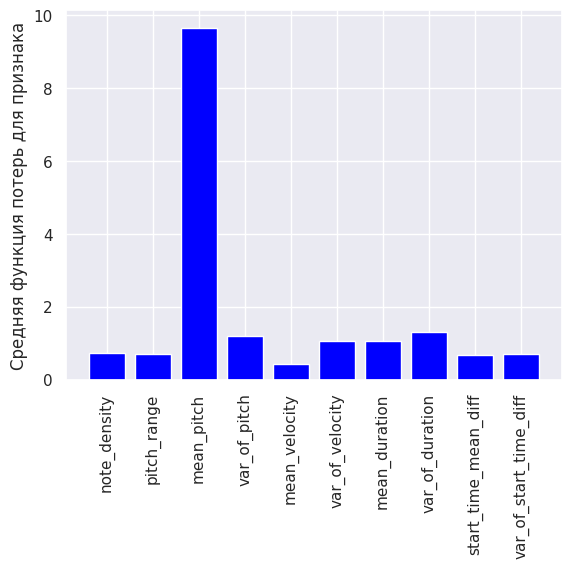

In [11]:
plt.bar(feature_names, global_mean_errors, color='blue')
plt.xticks(rotation=90)
plt.ylabel('Средняя функция потерь для признака')
plt.show()

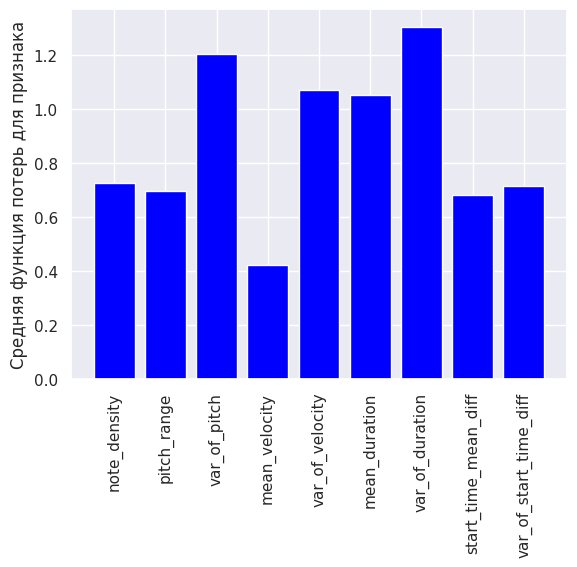

In [12]:
plt.bar(feature_names[:2] + feature_names[3:], np.delete(global_mean_errors, 2), color='blue')
plt.xticks(rotation=90)
plt.ylabel('Средняя функция потерь для признака')
plt.show()